# Imports

In [1]:
import pandas as pd
import numpy as np

from sklearn import cluster, datasets, mixture
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import normalize
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from scipy.stats import multivariate_normal

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('../../Datensaetze/news_POS_POS_tags_nouns_adjectives_verb.csv')
df.head(2)

,category,filename,title,content,number_of_tokens,number_of_types,stemmed_text,POS_tags,POS,nouns,adjectives,verb
0,business,001.txt,Ad sales boost Time Warner profit,Quarterly profits at US media giant TimeWarne...,415.0,244.0,quarterli profit at US media giant timewarn j...,"['_SP', 'NNP', 'NNS', 'IN', 'NNP', 'NNS', 'NN'...",high fourth own fourth underlying exceptional ...,74.0,22.0,1.0
1,business,002.txt,Dollar gains on Greenspan speech,The dollar has hit its highest level against ...,379.0,230.0,the dollar ha hit it highest level against th...,"['_SP', 'DT', 'NN', 'VBZ', 'VBN', 'PRP$', 'JJS...",late recent sanguine current current next shar...,66.0,30.0,9.0


# Daten vorbereiten

In [3]:
data = df[(df.category=='sport')|(df.category=='tech')]
data.head(1)

,category,filename,title,content,number_of_tokens,number_of_types,stemmed_text,POS_tags,POS,nouns,adjectives,verb
1313,sport,001.txt,Claxton hunting first major medal,British hurdler Sarah Claxton is confident sh...,206.0,145.0,british hurdler sarah claxton is confid she c...,"['_SP', 'JJ', 'NN', 'NNP', 'NNP', 'VBZ', 'JJ',...",British confident first major next old British...,29.0,22.0,5.0


In [4]:
data.shape

(912, 12)

In [5]:
tf_idf_vectorizor = TfidfVectorizer(max_features=1000,
                                    stop_words="english")
tf_idf = tf_idf_vectorizor.fit_transform(data.content)
tf_idf_norm = normalize(tf_idf)
tf_idf_array = tf_idf_norm.toarray()

# GMM

## BIC und AIC

Die Wahl der Anzahl der Komponenten misst wie gut GMM als density estimator funktioniert, nicht wie gut es als Clustering Algorithmus funktioniert.

Text(0.5, 0, 'n_components')

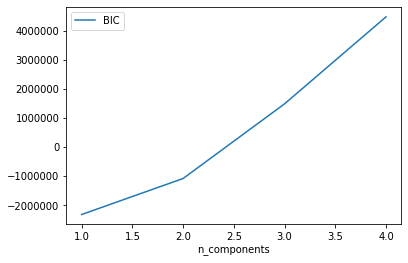

In [6]:
n_components = np.arange(1, 5)
models = [GaussianMixture(n, n_init=10, covariance_type='full', random_state=0).fit(tf_idf_array)
          for n in n_components]

plt.plot(n_components, [m.bic(tf_idf_array) for m in models], label='BIC')
plt.legend(loc='best')
plt.xlabel('n_components')

Text(0.5, 0, 'n_components')

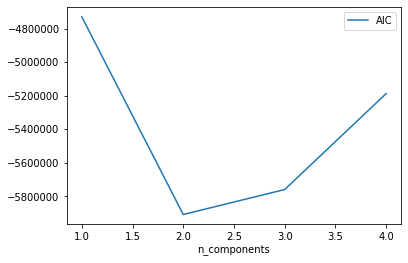

In [7]:
plt.plot(n_components, [m.aic(tf_idf_array) for m in models], label='AIC')
plt.legend(loc='best')
plt.xlabel('n_components')

In [8]:
def compute_PCA(text):
    pca = PCA(n_components = 2)
    Y = pca.fit_transform(text)
    return Y

In [9]:
def plot_PCA(Y, prediction):
    plt.figure(figsize=(15,10))
    plt.scatter(Y[:, 0], Y[:, 1], c=prediction, s=50, cmap='viridis')
    plt.title('PCA')
#     plt.savefig('K_Means/PCA_after_kmeans.png', bbox_inches = "tight")

## Hard Clustering

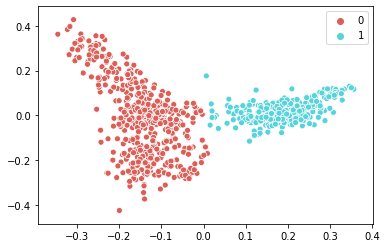

In [10]:
gmm = GaussianMixture(n_components=2, n_init=10, covariance_type='full').fit(tf_idf_array)
prediction = gmm.predict(tf_idf_array)
Y = compute_PCA(tf_idf_array)
sns.scatterplot(Y[:, 0], Y[:, 1],hue=prediction, palette=sns.color_palette("hls", len(np.unique(prediction))))

In [11]:
print(gmm.means_)
print('\n')
print(gmm.covariances_)

[[0.00484988 0.00743852 0.0108864  ... 0.0023853  0.00739476 0.00956526]
 [0.02036144 0.         0.0120859  ... 0.00517872 0.00202735 0.        ]]


[[[ 7.80000651e-04  6.29849159e-05  7.32655183e-05 ... -1.15684271e-05
   -2.06139839e-05 -1.03297767e-05]
  [ 6.29849159e-05  1.77459631e-03  4.84267513e-04 ...  1.03872885e-04
   -4.47437804e-05 -7.11514424e-05]
  [ 7.32655183e-05  4.84267513e-04  9.94434484e-04 ...  4.84236979e-05
    4.96596016e-05  7.33696521e-05]
  ...
  [-1.15684271e-05  1.03872885e-04  4.84236979e-05 ...  4.07122574e-04
   -1.43873634e-05 -2.28160603e-05]
  [-2.06139839e-05 -4.47437804e-05  4.96596016e-05 ... -1.43873634e-05
    9.17518180e-04  6.58477009e-05]
  [-1.03297767e-05 -7.11514424e-05  7.33696521e-05 ... -2.28160603e-05
    6.58477009e-05  2.18719659e-03]]

 [[ 1.31644354e-03  0.00000000e+00  1.13030362e-04 ...  8.92546218e-06
    7.98868844e-05  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e-06  0.00000000e+00 ...  0.00000000e+00
    0.00000000e+00  0.0

## Soft Clustering

In [12]:
probs = gmm.predict_proba(tf_idf_array)
print(probs[:5].round(3))

[[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]]


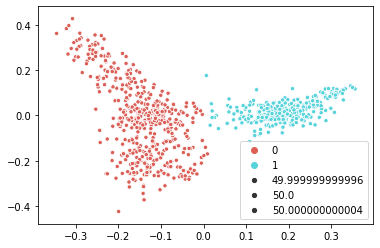

In [13]:
size = 50 * probs.max(1) ** 2  # square emphasizes differences
sns.scatterplot(Y[:, 0], Y[:, 1],hue=prediction, palette=sns.color_palette("hls", len(np.unique(prediction))), size=size)

In [14]:
def visualize_tsne(X_embedded, hue):
    fig = plt.figure(figsize=(8, 8))
    ax = plt.axes(frameon=False)
    plt.setp(ax, xticks=(), yticks=())
    plt.subplots_adjust(left=0.0, bottom=0.0, right=1.0, top=0.9,
                    wspace=0.0, hspace=0.0)
    num = len(np.unique(hue))
    sns.scatterplot(X_embedded[:, 0], X_embedded[:, 1],hue=hue, marker="o", palette=sns.color_palette("hls", num), legend=False)
    plt.title("Songtexte")
#     plt.savefig(figname)
    plt.show()

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 912 samples in 0.225s...
[t-SNE] Computed neighbors for 912 samples in 1.496s...
[t-SNE] Computed conditional probabilities for sample 912 / 912
[t-SNE] Mean sigma: 0.404573
[t-SNE] Computed conditional probabilities in 0.078s
[t-SNE] Iteration 50: error = 185.4063416, gradient norm = 0.1719434 (50 iterations in 0.564s)
[t-SNE] Iteration 100: error = 185.4101715, gradient norm = 0.1707678 (50 iterations in 0.561s)
[t-SNE] Iteration 150: error = 185.3939056, gradient norm = 0.1297489 (50 iterations in 0.564s)
[t-SNE] Iteration 200: error = 185.3933868, gradient norm = 0.1279706 (50 iterations in 0.601s)
[t-SNE] Iteration 250: error = 185.4096069, gradient norm = 0.1679561 (50 iterations in 0.625s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 185.409607
[t-SNE] Iteration 300: error = 1.1029270, gradient norm = 0.0019744 (50 iterations in 0.485s)
[t-SNE] Iteration 350: error = 0.9355188, gradient norm = 0.00

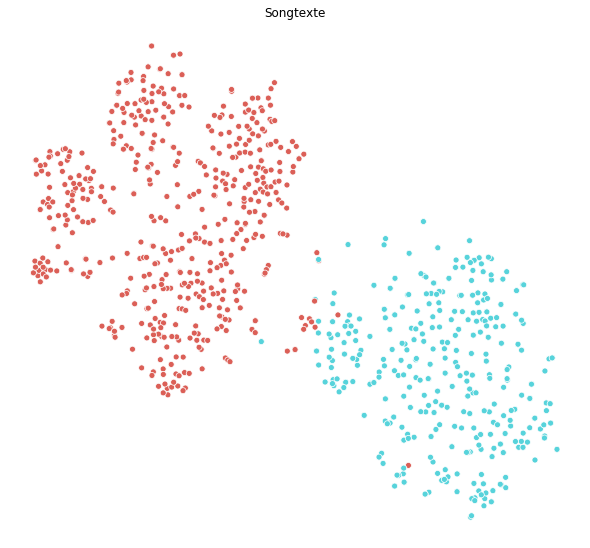

In [15]:
# perplexity = [2,5,10,30,40,50,100]

perplexity = [50]
for p in perplexity:
    X_embedded = TSNE(n_components=2, perplexity=p, early_exaggeration=30,learning_rate=50, verbose=2).fit_transform(tf_idf_array)
    figname = "tsne_songtextegekuerzt_perplexity"+str(p)
    visualize_tsne(X_embedded, prediction)